# Series

A ``Series`` object is a distributed collection of 1D arrays, all of which share a common index. It supports several manipulations and computations on 1D data, some of which take the index into account.

The most common examples of Series objects are likely time series data, in which each array represents a quantity that has been temporally sampled at regular intervals. For example, a movie can be represented as Series data, where a single record might consist of a pixel time series, as in the `fish-series` and `mouse-series` example data from the `basic usage` tutorial.

The keys associated with Series records can be any data used to identify the series, for example, a single sensor channel identifier, or tuples representing pixel coordiantes (if derived from a movie). For example, a Series record representing a time series from an outer corner of a movie might have key (0, 0, 0), with the value being an array representing the measurements at that location over time: [112, 110, 118, ..., 124].

Here, we show examples of loading and manipulating Series data.

Setup plotting
--------------

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

Loading series
--------------
Series can be loaded from a ``ThunderContext`` using the `loadSeries` method. (See the ``Input formats`` tutorial for more detail on loading methods and formats.) Here, we'll again load the "fish-series" example data set:

In [3]:
data = tsc.loadExample('fish-series')

Inspection
----------
Let's plot a random subset of the data using the ``subset`` method, which thresholds based on the standard deviation:

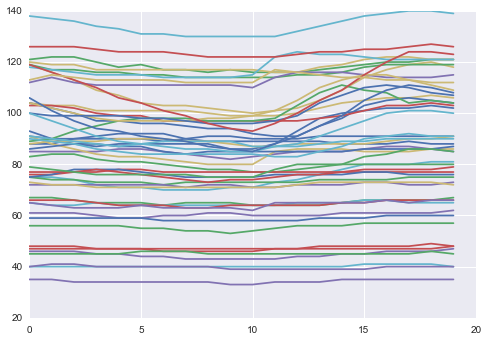

In [4]:
examples = data.subset(nsamples=50, thresh=1)
plt.plot(examples.T[0:20,:]);

Note the variation in raw intensity levels.

Processing
-------------
A ``Series`` object has various methods for processing and transforming the data. For example, ``center`` subtracts the mean, ``squelch`` sets to 0 any records not exceeding a threshold, and ``zscore`` subtracts the mean and divides by the standard deviation. Note the changes in the y-axis.

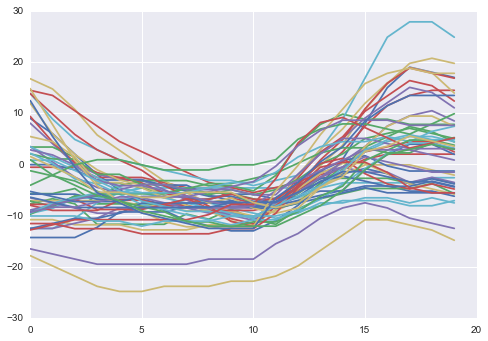

In [5]:
examples = data.center().subset(nsamples=50, thresh=10)
plt.plot(examples.T[0:20,:]);

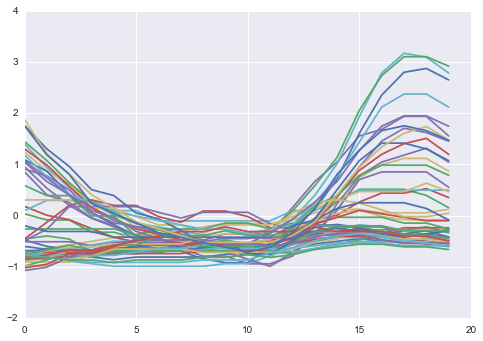

In [6]:
examples = data.squelch(150).zscore().subset(nsamples=50, thresh=0.1)
plt.plot(examples.T[0:20,:]);

Related methods include ``standardize``, ``detrend``, and ``normalize`` (the latter two are specified to `TimeSeries`, see below)

Selections
----------
A ``Series`` has a 1D index, which can be used to subselect values.

In [7]:
data.index.shape

(240,)

For example, to select a range:

In [8]:
data.between(0,8).first()

((0, 0, 0), array([ 26.,  26.,  26.,  26.,  26.,  26.,  26.,  25.,  26.]))

Note that the index changes to reflect the subselected range:

In [9]:
data.between(0,8).index

[0, 1, 2, 3, 4, 5, 6, 7, 8]

We can also select based on an arbitrary criterion function:

In [10]:
data.select(lambda x: x < 5).index

[0, 1, 2, 3, 4]

The default index generated for ``Series`` objects will be the range of integers starting at zero and ending one before the length of the series data, as shown in these examples. However, other data types can also be used as the index for a series object, such as a sequence of strings, providing text labels for each element in the series array, or a tuple with indices at different levels. See the tutorial on Multi-indexing tutorial for this usage.

Statistics
----------
A ``Series`` can be summarized with statistics both within and across records. To summarize across records:

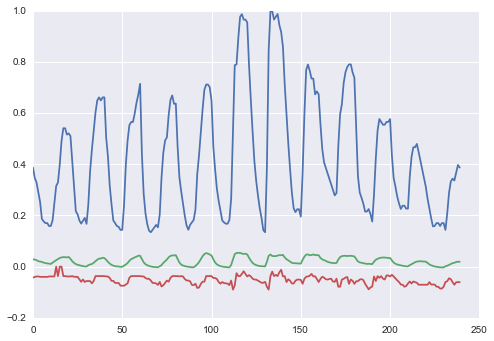

In [11]:
plt.plot(data.toTimeSeries().normalize().max());
plt.plot(data.toTimeSeries().normalize().mean());
plt.plot(data.toTimeSeries().normalize().min());

To summarize within records:

In [12]:
data.seriesMean().first()

((0, 0, 0), 25.824999999999999)

In [13]:
data.seriesStdev().first()

((0, 0, 0), 0.37996710383926657)

We can also correlate each record with a signal of interest. As expected, for a random signal, the correlation should be near 0.

In [14]:
from numpy import random
signal = random.randn(240)
data.correlate(signal).first()

((0, 0, 0), 0.063411240679893649)

Keys
----
We often use integer keys to index the records of a ``Series``, and sometimes these keys represent indices into some original array (for example, indices into a multi-dimensional tensor, or pixel coordinates if the records are time series from a movie).

A few convenience methods are provided for working with keys. First, the attribute ``dims`` contains information about the range of the keys. Computing this requires a pass through the data, but if computed on a ``Series`` it will be inherited by all derived objects, to avoid recomputation.

In [15]:
data.dims.max

(75, 86, 1)

In [16]:
data.dims.min

(0, 0, 0)

For keys that correspond to subscripts (e.g. indices of the rows and columns of a matrix, coordinates in space), we can convert between subscript and linear indexing. The default for these conversions is currently onebased subscript indexing, so we need to set ``onebased`` to ``False`` (this will likely change in a future release).

In [17]:
data.keys().take(10)

[(0, 0, 0),
 (1, 0, 0),
 (2, 0, 0),
 (3, 0, 0),
 (4, 0, 0),
 (5, 0, 0),
 (6, 0, 0),
 (7, 0, 0),
 (8, 0, 0),
 (9, 0, 0)]

In [18]:
data.subToInd(isOneBased=False).keys().take(10)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [19]:
data.subToInd(isOneBased=False).indToSub(isOneBased=False).keys().take(10)

[(0, 0, 0),
 (1, 0, 0),
 (2, 0, 0),
 (3, 0, 0),
 (4, 0, 0),
 (5, 0, 0),
 (6, 0, 0),
 (7, 0, 0),
 (8, 0, 0),
 (9, 0, 0)]

The ``query`` method can be used to average subselected records based on their (linearized) keys. It returns the mean value and  key for each of the provided index lists.

In [20]:
keys, values = data.query(inds=[[100,101],[200]], isOneBased=False)

In [21]:
keys

array([[ 25.5,   1. ,   0. ],
       [ 50. ,   2. ,   0. ]])

In [22]:
values.shape

(2, 240)

The ``pack`` method collects a series into a local array, reshaped based on the keys. If there are multiple values per record, all will be collected into the local array, so typically we select a subset of values before packing to avoid overwhelming the local returning a very large amount of data.

In [23]:
out = data.select(0).pack()
out.shape

(76, 87, 2)

In [24]:
out = data.between(0,2).pack()
out.shape

(3, 76, 87, 2)

Conversions
-----------
Subclasses of ``Series`` provide additional functionality for more specialized data types.

A ``TimeSeries`` provides methods specific to time-varying data, like ``fourier``, for computing the statistics of a Fourier transform:

In [25]:
ts = data.toTimeSeries()
fr = ts.fourier(freq=5)
fr.index

['coherence', 'phase']

In [26]:
fr.select('coherence').first()

((0, 0, 0), 0.17186687287857189)

Or detrend for detrending data over time

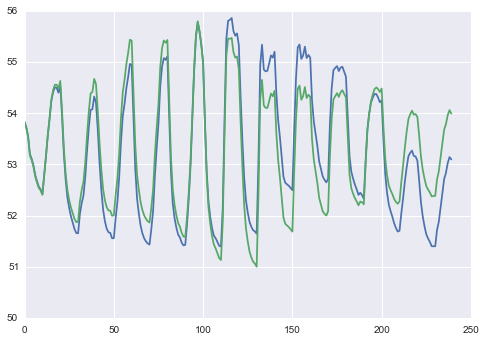

In [27]:
plt.plot(ts.mean())
plt.plot(ts.detrend('nonlinear', order=5).mean());

A ``RowMatrix`` provides a variety of methods for working with distributed matrices and matrix operations:

In [28]:
mat = data.toRowMatrix()

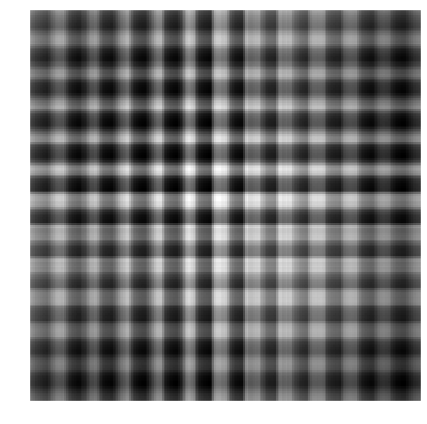

In [29]:
from thunder import Colorize
Colorize.image(mat.cov())